# Operation test design

A draft notebook to design the scenarios for testing Microgrids.jl `operation`+`aggregation` function

In [1]:
using Microgrids

In [2]:
using PyPlot

## Setup data

### Synthetic time series

- Irradiance: daily periodicity in [0,1]. zero à midnight, one at midday
- Load: linear decrease so that there should be:
  - load shedding at the beginning
  - solar spillage at the end

In [3]:
dt_1h = 1. # h
dt_30m = 0.5 # h

Pload_max = 1000.0 # kW
ndays = 7

7

In [4]:
K_1h = Int(ndays*24/dt_1h)
println("Number of timesteps: $K_1h for dt=$dt_1h")

t_1h = (0:K_1h-1)*dt_1h
@assert length(t_1h) == K_1h
td_1h = t_1h/24

irradiance_1h = @. 0.5* (1 - cos(2*pi*t_1h/24)) # in [0,1]
Pload_1h = collect(1 .- td_1h/ndays)*Pload_max;

Number of timesteps: 168 for dt=1.0


In [5]:
K_30m = Int(ndays*24/dt_30m)
println("Number of timesteps: $K_30m (for dt=$dt_30m)")

t_30m = (0:K_30m-1)*dt_30m
td_30m = t_30m/24

irradiance_30m = @. 0.5* (1 - cos(2*pi*t_30m/24)) # in [0,1]
Pload_30m = collect(1 .- td_30m/ndays)*Pload_max
@assert length(Pload_30m) == K_30m;

Number of timesteps: 336 (for dt=0.5)


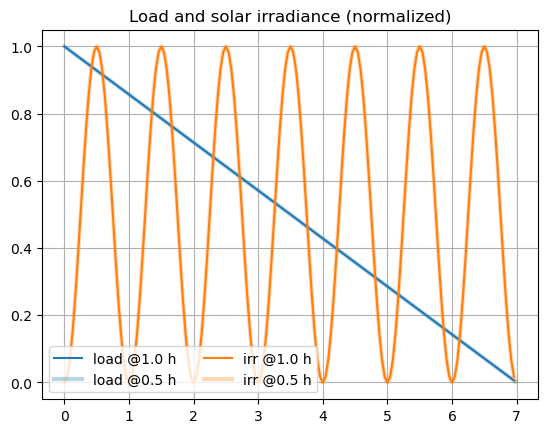

In [6]:
plot(td_1h, Pload_1h/Pload_max, "C0", label="load @$dt_1h h")
plot(td_30m, Pload_30m/Pload_max, "C0", label="load @$dt_30m h",
     lw=3, alpha=0.3)

plot(td_1h, irradiance_1h, "C1", label="irr @$dt_1h h")
plot(td_30m, irradiance_30m, "C1", label="irr @$dt_30m h",
     lw=3, alpha=0.3)

title("Load and solar irradiance (normalized)")
legend(ncols=2)
grid(true)

### Parameters

In [7]:
# Project
lifetime = 25 # yr
discount_rate = 0.05

# Parameters common to all Components
replacement_price_ratio = 1.0
salvage_price_ratio = 1.0

# Dispatchable generator
power_rated_gen = 500.
fuel_intercept_0 = 0.00 # constant efficiency generator
fuel_intercept_5 = 0.05
fuel_slope = 0.240
fuel_price = 1.
investment_price_gen = 400.
om_price_gen = 0.02
lifetime_gen = 15000.
load_ratio_min = 0.0
fuel_unit = "L"

# Battery energy storage
energy_rated = 6000.
investment_price_sto = 350.
om_price_sto = 10.
lifetime_sto = 15.
lifetime_cycles = 3000.
charge_rate = 1.0
charge_rate_slow = 1.0/30 # 200 kW charging
discharge_rate = 1.0
discharge_rate_slow = 1.0/30 # 200 kW discharging
loss_factor_sto = 0.05
SoC_min = 1/6 # 1000 kWh
SoC_ini = 1/3 # 2000 kWh

# Photovoltaic generation
power_rated_pv = 1000. # set in x
investment_price_pv = 1200.
om_price_pv = 20.
lifetime_pv = 25.
derating_factor_pv = 1.

println("slow charging power: $(charge_rate_slow*energy_rated) kW")
println("slow discharging power: $(discharge_rate_slow*energy_rated) kW")

slow charging power: 200.0 kW
slow discharging power: 200.0 kW


### Microgrid components

In [8]:
# generator with constant efficiency
gen0 = DispatchableGenerator(power_rated_gen,
    fuel_intercept_0, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen, lifetime_gen,
    load_ratio_min,
    replacement_price_ratio, salvage_price_ratio, fuel_unit)
gen = DispatchableGenerator(power_rated_gen,
    fuel_intercept_5, fuel_slope, fuel_price,
    investment_price_gen, om_price_gen, lifetime_gen,
    load_ratio_min,
    replacement_price_ratio, salvage_price_ratio, fuel_unit)

batt = Battery(energy_rated,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
    replacement_price_ratio, salvage_price_ratio)
# battery with slow charging capability
batt_slow_charge = Battery(energy_rated,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate_slow, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
    replacement_price_ratio, salvage_price_ratio)
# battery with slow discharging capability
batt_slow_discharge = Battery(energy_rated,
    investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
    charge_rate, discharge_rate_slow, loss_factor_sto, SoC_min, SoC_ini,
    replacement_price_ratio, salvage_price_ratio)

pv = Photovoltaic(power_rated_pv, irradiance_1h,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)
# halved PV plant
pv_half = Photovoltaic(power_rated_pv/2, irradiance_1h,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)
pv_30m = Photovoltaic(power_rated_pv, irradiance_30m,
    investment_price_pv, om_price_pv,
    lifetime_pv, derating_factor_pv,
    replacement_price_ratio, salvage_price_ratio)

Photovoltaic{Float64}(1000.0, [0.0, 0.004277569313094809, 0.017037086855465844, 0.03806023374435663, 0.06698729810778065, 0.10332332985438242, 0.1464466094067262, 0.19561928549563967, 0.24999999999999994, 0.3086582838174551  …  0.3705904774487406, 0.308658283817454, 0.2500000000000033, 0.195619285495641, 0.14644660940672838, 0.10332332985438297, 0.06698729810778009, 0.038060233744356686, 0.017037086855465344, 0.0042775693130951975], 1200.0, 20.0, 25.0, 1.0, 1.0, 1.0)

### Microgrid variants

In [9]:
proj = Project(lifetime, discount_rate, dt_1h, "€")
proj_30m = Project(lifetime, discount_rate, dt_30m, "€")

mg_base = Microgrid(proj, Pload_1h, gen, batt, [pv])
# Microgrid with two halved PV plant → should be identical to base
mg_2pv = Microgrid(proj, Pload_1h, gen0, batt, [pv_half, pv_half])
# Microgrid with 30 min time step → should give similar stats
mg_30m = Microgrid(proj_30m, Pload_30m, gen, batt, [pv_30m])
# Microgrid with constant efficiency generator → less fuel but same hours
mg_gen0 = Microgrid(proj, Pload_1h, gen0, batt, [pv])
# Microgrids with battery with slow (dis)-charging capability
mg_slow_charge = Microgrid(proj, Pload_1h, gen, batt_slow_charge, [pv])
mg_slow_discharge = Microgrid(proj, Pload_1h, gen, batt_slow_discharge, [pv])

Microgrid{Float64}(Project(25, 0.05, 1.0, "€"), [1000.0, 994.047619047619, 988.0952380952382, 982.1428571428571, 976.1904761904761, 970.2380952380952, 964.2857142857143, 958.3333333333334, 952.3809523809523, 946.4285714285714  …  59.52380952380952, 53.57142857142857, 47.61904761904761, 41.666666666666664, 35.714285714285715, 29.76190476190476, 23.809523809523807, 17.857142857142858, 11.904761904761903, 5.952380952380952], DispatchableGenerator{Float64}(500.0, 0.05, 0.24, 1.0, 400.0, 0.02, 15000.0, 0.0, 1.0, 1.0, "L"), Battery{Float64}(6000.0, 350.0, 10.0, 15.0, 3000.0, 1.0, 0.03333333333333333, 0.05, 0.16666666666666666, 0.3333333333333333, 1.0, 1.0), Photovoltaic{Float64}[Photovoltaic{Float64}(1000.0, [0.0, 0.017037086855465844, 0.06698729810778065, 0.1464466094067262, 0.24999999999999994, 0.37059047744873963, 0.49999999999999994, 0.6294095225512604, 0.7499999999999999, 0.8535533905932737  …  0.9330127018922199, 0.8535533905932741, 0.7499999999999997, 0.6294095225512628, 0.50000000000

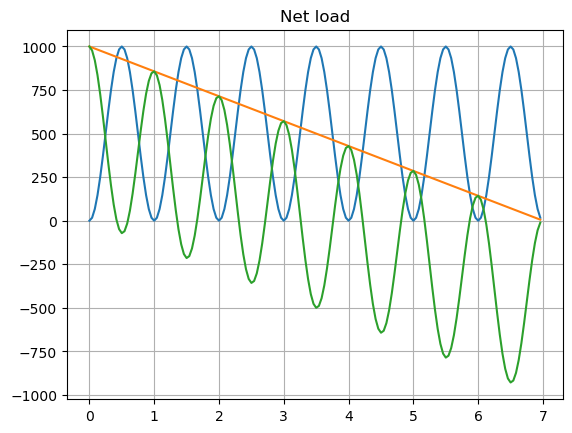

PyObject Text(0.5, 1.0, 'Net load')

In [10]:
Pnl_1h = Pload_1h - production(pv)
plot(td_1h, production(pv))
plot(td_1h, Pload_1h)
plot(td_1h, Pnl_1h)

grid(true)
title("Net load")

## Simulations

In [11]:
function simulate_traj_stats(mg)
    # Run the microgrid operation
    oper_traj = operation(mg)
    # Aggregate the operation variables
    oper_stats = aggregation(mg, oper_traj)
    return oper_traj, oper_stats
end

simulate_traj_stats (generic function with 1 method)

In [12]:
function plot_traj(td, oper_traj)
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=true)
    ax1.plot(td_1h, Pnl_1h, label="Pnl*")
    ax1.plot(td, oper_traj.Pgen, "C3", label="gen")
    ax1.plot(td, oper_traj.Pbatt, "C2", label="batt")
    
    ax2.plot(td, oper_traj.power_shedding-oper_traj.power_curtailment, "C6", label="Pshed − Pspill")
    
    ax3.plot(td, oper_traj.Ebatt[1:end-1], "C2", label="Ebatt")
    
    ax1.legend(ncols=3)
    ax1.grid(true)
    ax1.set(
        ylabel="kW"
    )
    ax2.legend()
    ax2.grid(true)
    ax2.set(
        ylabel="kW",
        ylim=ax1.get_ylim()
    )
    ax3.legend()
    ax3.grid(true)
    ax3.set(
        xlabel="time (d)",
        ylabel="kWh",
        ylim = (energy_rated*-0.05, energy_rated*1.05)
    )
    fig.tight_layout()
    return fig, (ax1, ax2, ax3)
end

plot_traj (generic function with 1 method)

### Base case

In [13]:
traj_base, stats_base = simulate_traj_stats(mg_base)
stats_base # Multi-line display

OperationStats with fields:
- served_energy: 79512.0 kWh
- shed_energy: 4988.2 kWh
- shed_max: 477.01 kW
- shed_hours: 24.0 h
- shed_duration_max: 10.0 h
- shed_rate: 0.059032 in [0,1]
- gen_energy: 17703.0 kWh
- gen_hours: 48.0 h
- gen_fuel: 5448.7 L
- storage_cycles: 1.9837 
- storage_char_energy: 14497.0 kWh
- storage_dis_energy: 9307.0 kWh
- storage_loss_energy: 1190.2 kWh
- spilled_energy: 17001.0 kWh
- spilled_max: 928.57 kW
- spilled_rate: 0.20239 in [0,1]
- renew_potential_energy: 84000.0 kWh
- renew_energy: 66999.0 kWh
- renew_rate: 0.77736 in [0,1]


Compact display:

In [14]:
println(stats_base)

OperationStats(79511.7634897933, 4988.236510206714, 477.01053219215305, 24.0, 10.0, 0.05903238473617412, 17702.87093198049, 48.0, 5448.689023675317, 1.9836794636446038, 14497.180620961004, 9306.972942774242, 1190.2076781867618, 17000.89976400046, 928.5714285714286, 0.20239166385714832, 84000.0, 66999.10023599953, 0.7773553225963482)


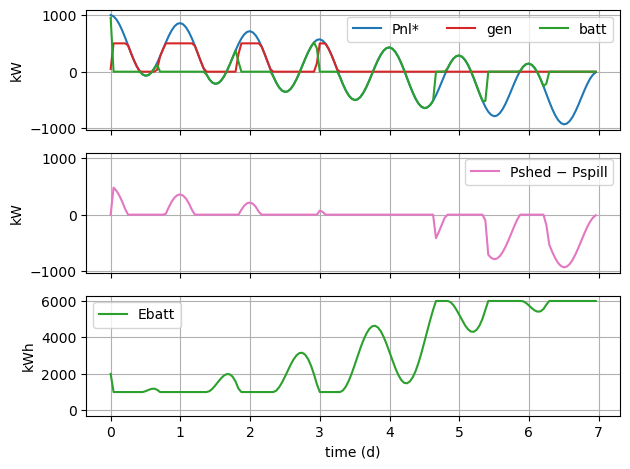

In [15]:
plot_traj(td_1h, traj_base);

### Variant: slow charging

OperationStats(79451.41962426782, 5048.580375732201, 477.01053219215305, 25.0, 10.0, 0.059746513322274555, 19360.131440266126, 54.0, 5996.431545663869, 1.6823453629759861, 12598.775786748713, 7589.368568963121, 1009.4072177855915, 18899.304598212748, 799.9819620218456, 0.22499172140729462, 84000.0, 65100.69540178725, 0.7563274321362443)


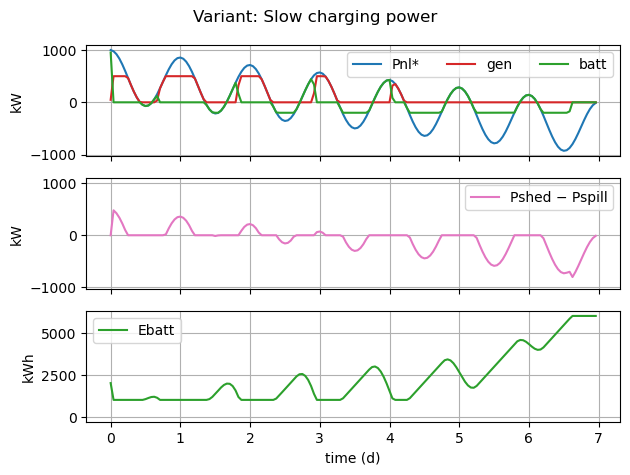

OperationStats with fields:
- served_energy: 79451.0 kWh
- shed_energy: 5048.6 kWh
- shed_max: 477.01 kW
- shed_hours: 25.0 h
- shed_duration_max: 10.0 h
- shed_rate: 0.059747 in [0,1]
- gen_energy: 19360.0 kWh
- gen_hours: 54.0 h
- gen_fuel: 5996.4 L
- storage_cycles: 1.6823 
- storage_char_energy: 12599.0 kWh
- storage_dis_energy: 7589.4 kWh
- storage_loss_energy: 1009.4 kWh
- spilled_energy: 18899.0 kWh
- spilled_max: 799.98 kW
- spilled_rate: 0.22499 in [0,1]
- renew_potential_energy: 84000.0 kWh
- renew_energy: 65101.0 kWh
- renew_rate: 0.75633 in [0,1]


In [16]:
mg = mg_slow_charge
traj, stats = simulate_traj_stats(mg)

fig, (ax1, ax2, ax3) = plot_traj(td_1h, traj)
fig.suptitle("Variant: Slow charging power")
fig.tight_layout()

println(stats)
stats # Multi-line display

### Variant: slow discharging

As a side note, the *shedding rate is lower than the base case* (this relates to the undersized generator...) → idea for an improved rule-based energy management...

OperationStats(80171.36085007957, 4328.639149920452, 357.1428571428571, 22.0, 10.0, 0.05122649881562664, 19764.429914552697, 67.0, 6418.463179492646, 1.737721284296193, 12947.644091066019, 7905.0113204883, 1042.6327705777185, 18550.436293895444, 928.5714285714286, 0.2208385273082791, 84000.0, 65449.563706104556, 0.7534726901853122)


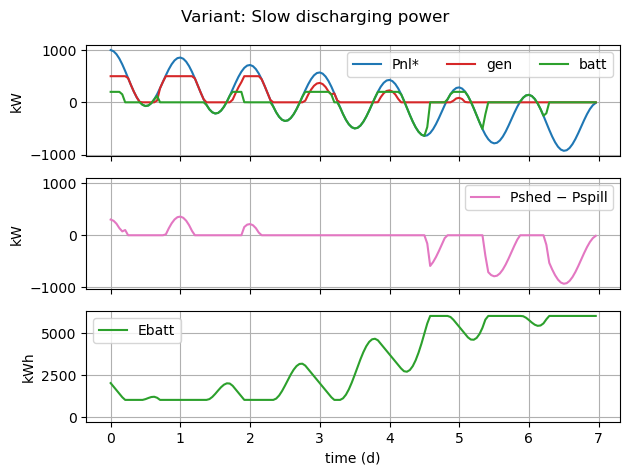

OperationStats with fields:
- served_energy: 80171.0 kWh
- shed_energy: 4328.6 kWh
- shed_max: 357.14 kW
- shed_hours: 22.0 h
- shed_duration_max: 10.0 h
- shed_rate: 0.051226 in [0,1]
- gen_energy: 19764.0 kWh
- gen_hours: 67.0 h
- gen_fuel: 6418.5 L
- storage_cycles: 1.7377 
- storage_char_energy: 12948.0 kWh
- storage_dis_energy: 7905.0 kWh
- storage_loss_energy: 1042.6 kWh
- spilled_energy: 18550.0 kWh
- spilled_max: 928.57 kW
- spilled_rate: 0.22084 in [0,1]
- renew_potential_energy: 84000.0 kWh
- renew_energy: 65450.0 kWh
- renew_rate: 0.75347 in [0,1]


In [17]:
mg = mg_slow_discharge
traj, stats = simulate_traj_stats(mg)

fig, (ax1, ax2, ax3) = plot_traj(td_1h, traj)
fig.suptitle("Variant: Slow discharging power")
fig.tight_layout()

println(stats)
stats # Multi-line display